In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from mplsoccer import Pitch, VerticalPitch
from IPython.display import set_matplotlib_formats

set_matplotlib_formats('retina')

/var/folders/yn/w3h701111q199y7qdtvn61940000gn/T/ipykernel_76724/3090608349.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/Users/g4din/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/var/folders/yn/w3h701111q199y7qdtvn61940000gn/T/ipykernel_76724/3090608349.py:17: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inl

In [2]:
# Import data
damallsvenskan = pd.read_csv('csv/damallsvenskan_all.csv')
allsvenskan = pd.read_csv('csv/allsvenskan_all.csv')

# concatenate the two datasets
allsvenskan = pd.concat([allsvenskan, damallsvenskan])

In [3]:
# Assuming 'damallsvenskan' is your dataframe
# Create a column to identify if the next action is a goal
allsvenskan['is_next_goal'] = (allsvenskan['action'].shift(-1) == 'Goal').astype(int)

# Identify shots and whether they resulted in a goal
allsvenskan['is_shot'] = (allsvenskan['action'] == 'Shot').astype(int)
shots = allsvenskan[allsvenskan['is_shot'] == 1]

# Scale coordinates
scale_x = lambda x: x * 120 / 100
scale_y = lambda y: y * 80 / 100

# Apply scaling directly to the dataframe
shots['x'] = shots['xpos'].apply(scale_x)
shots['y'] = shots['ypos'].apply(scale_y)

# Convert 'is_next_goal' to boolean
shots['goal'] = shots['is_next_goal'].astype(bool)

# Select the required columns to form the new dataframe
data = shots[['x', 'y', 'goal']]

# Assuming 'header' is the column you want to add from 'allsvenskan'
data['header'] = shots['header']

/var/folders/yn/w3h701111q199y7qdtvn61940000gn/T/ipykernel_76724/174589336.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shots['x'] = shots['xpos'].apply(scale_x)
/var/folders/yn/w3h701111q199y7qdtvn61940000gn/T/ipykernel_76724/174589336.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shots['y'] = shots['ypos'].apply(scale_y)
/var/folders/yn/w3h701111q199y7qdtvn61940000gn/T/ipykernel_76724/174589336.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

In [4]:
# Define functions for calculating distance and angle
def calculate_angle(x, y):
    width = 7.32
    new_x = 120 - x
    new_y = abs(y - 40)
    tan_theta = (width * new_x) / (new_x**2 + new_y**2 - (width/2)**2)
    theta = np.arctan(tan_theta) * (180 / np.pi)  # Convert radians to degrees
    return theta

def calculate_dist(x, y):
    return np.sqrt((120 - x)**2 + (40 - y)**2)

# Apply the functions to the dataframe
data['angle'] = data.apply(lambda row: calculate_angle(row['x'], row['y']), axis=1)
data['distance'] = data.apply(lambda row: calculate_dist(row['x'], row['y']), axis=1)

data.head(10)

/var/folders/yn/w3h701111q199y7qdtvn61940000gn/T/ipykernel_76724/1493875045.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['angle'] = data.apply(lambda row: calculate_angle(row['x'], row['y']), axis=1)
/var/folders/yn/w3h701111q199y7qdtvn61940000gn/T/ipykernel_76724/1493875045.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['distance'] = data.apply(lambda row: calculate_dist(row['x'], row['y']), axis=1)


,x,y,goal,header,angle,distance
74,109.2,55.2,False,False,13.305603,18.646179
106,111.6,24.8,False,False,12.043411,17.366635
114,98.4,30.4,False,False,16.169050,23.637259
163,114.0,39.2,True,True,62.110234,6.053098
269,92.4,44.0,False,False,14.805480,27.888349
337,111.6,24.8,False,False,12.043411,17.366635
353,116.4,37.6,True,True,78.577219,4.326662
428,112.8,26.4,True,False,13.274114,15.388307
453,104.4,41.6,True,False,26.155509,15.681837
483,109.2,48.0,False,False,25.299982,13.440238


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Assuming df is your DataFrame
X = data[['distance', 'angle', 'header']]
y = data['goal'].astype(int)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline for SVM
svm_model = make_pipeline(StandardScaler(), SVC(probability=True))
svm_model.fit(X_train, y_train)

# Evaluate the model
test_accuracy = svm_model.score(X_test, y_test)
print(f'Test Accuracy: {test_accuracy}')

Test Accuracy: 0.8957613814756672


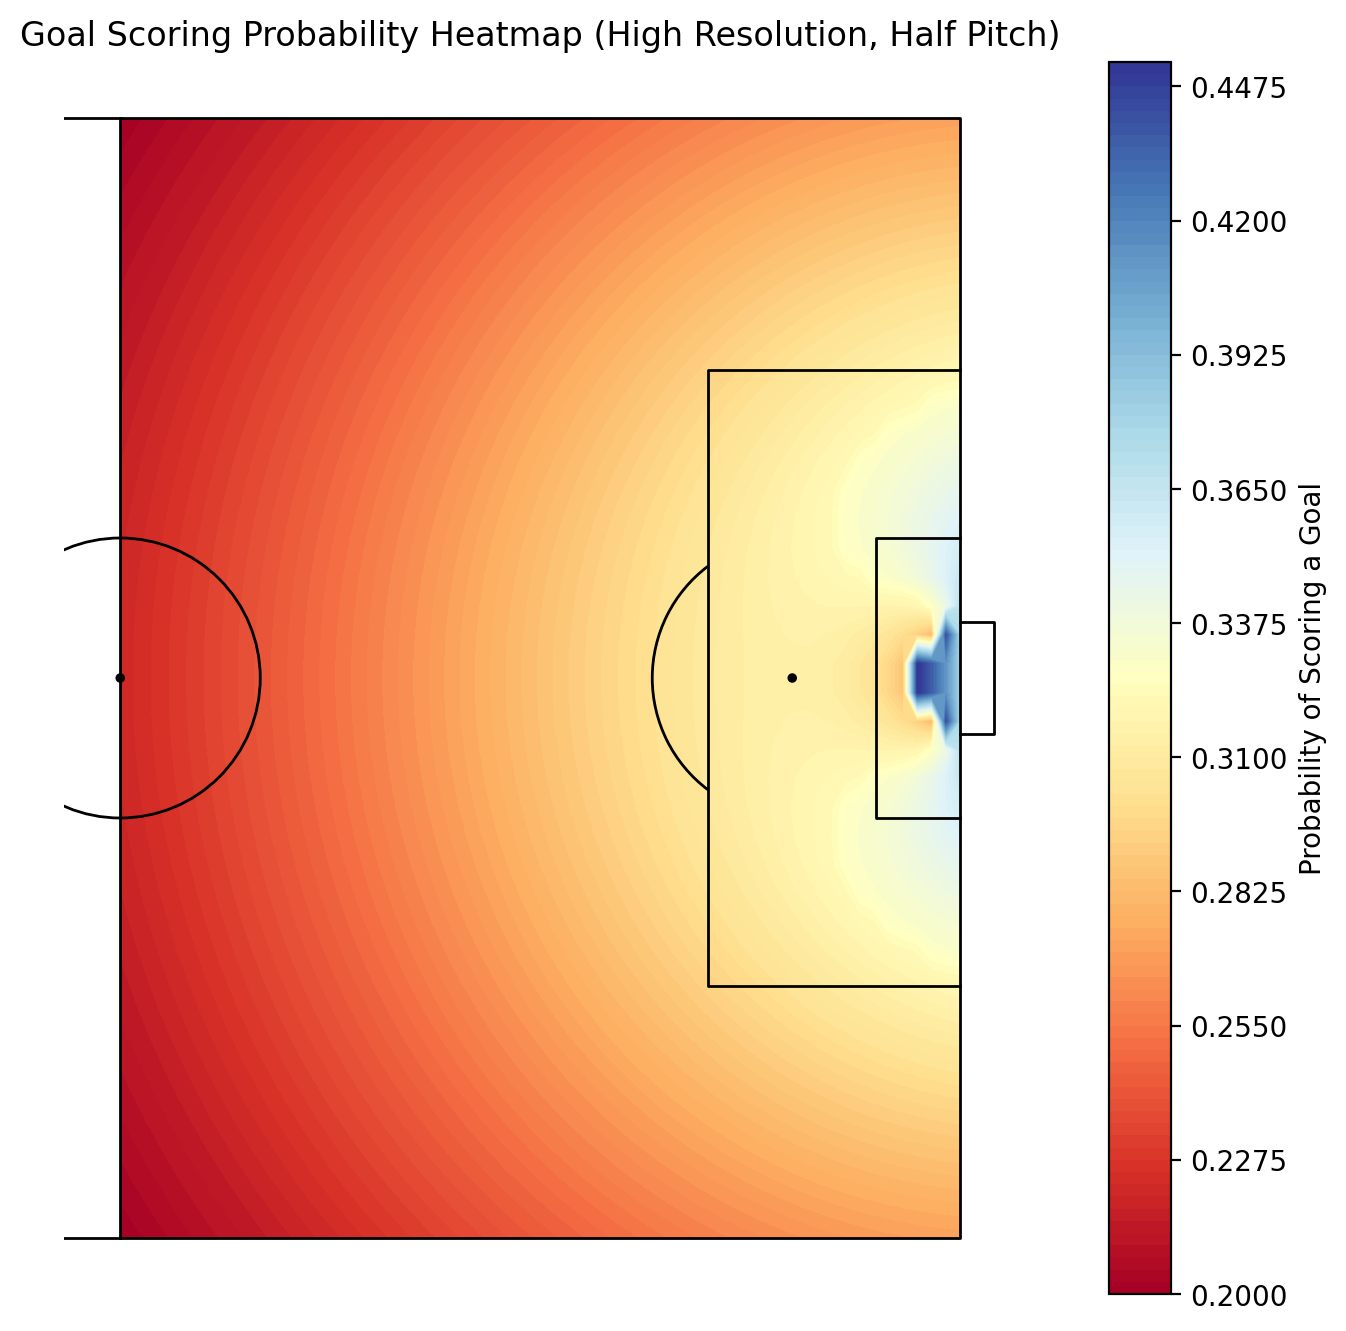

In [12]:
# Adjusted grid for higher resolution
x_values = np.linspace(60, 120, 60)  # Increase the number of points for finer resolution
y_values = np.linspace(0, 80, 40)   # Increase the number of points for finer resolution
xx, yy = np.meshgrid(x_values, y_values)
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Assuming header is binary, let's add header = 0 for non-header attempts
# Update this line to create a full feature set including the header
# For simplicity, this example assumes all attempts are non-header. Adjust if needed.
full_grid_points = np.array([[calculate_dist(x, y), calculate_angle(x, y), 0] for x, y in grid_points])  # Assuming header=0

# Scale the features as before and predict goal probabilities
scaled_full_grid_points = svm_model.named_steps['standardscaler'].transform(full_grid_points)  # Use fitted scaler
goal_probabilities = svm_model.predict_proba(scaled_full_grid_points)[:, 1]  # Probability predictions

# Reshape for plotting
goal_prob_matrix = goal_probabilities.reshape(xx.shape)

# Plotting with increased resolution
fig, ax = plt.subplots(figsize=(12, 8))
pitch = Pitch(half=True, goal_type='box', line_zorder=2, line_color='black', linewidth=1)
pitch.draw(ax=ax)
contour = ax.contourf(xx, yy, goal_prob_matrix, cmap='RdYlBu', levels=100, zorder=1)  # Increase levels for smoother gradient
fig.colorbar(contour, ax=ax, label='Probability of Scoring a Goal')
ax.set_title('Goal Scoring Probability Heatmap (High Resolution, Half Pitch)')

plt.show()